In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from pyemd import emd
from sklearn.metrics import pairwise
from sklearn.metrics import accuracy_score
# %matplotlib inline

In [2]:
class FileUtilities(object):
    """ 
        Reads the CSI data 
    """
    def __init__(self, path):
        super(FileUtilities, self).__init__()
        self.path = path
        self.data_matrices = []
        self.amplitude = []
        self.labels = []
        print("FileUtilities initialized")
        
    def read_csv(self,file):
        return pd.read_csv(file)

    def get_data_matrix(self,df):
        """ Returns the timestamps, amplitude and phase as a single matrix """
        return(df.as_matrix())

    def get_data_matrices(self):
        files = os.listdir(self.path)
        for file in files:
            df = self.read_csv(self.path+file)
            # label = str(str(file).split('-')[1])
            label = str(str(file).split('_')[3])
            self.labels.append(label)
            print("Reading " + str(file) + "...")
            data = self.get_data_matrix(df)
            self.data_matrices.append(data)
        print("FileUtilities::get_data_matrices read %d files" %(len(self.data_matrices)))
        return self.data_matrices

    def get_amplitude_matrices(self):
        if not self.data_matrices:
            self.get_data_matrices()
        for data_matrix in self.data_matrices:
            self.amplitude.append(np.array(data_matrix[:,1:]))		# for new data
            # self.amplitude.append(np.array(data_matrix[:,1:91]))
        return self.amplitude
    
    def plot_reading_amp_summed(self,input_file):
        df = self.read_csv(self.path+input_file)
        data = self.get_data_matrix(df)
        s = data[:,1:31]
        res = np.sum(s,axis = 0)
        return res
    
    def plot_reading_amp_subcarrier(self,input_file,subcarrier_index):
        df = self.read_csv(self.path+input_file)
        data = self.get_data_matrix(df)
        s = data[:,subcarrier_index]
        return s

In [3]:
class MovingVariance(object):
	""" Calculates moving variance """
	def __init__(self, C, window):
		super(MovingVariance, self).__init__()
		self.C_ = C
		self.window_ = window
		print("MovingVariance initialized")

	def get_moving_var(self):
		return pd.rolling_var(self.C_,self.window_)
	
	def get_cumulative_moving_variance(self,V):
		return np.sum(V,axis=1)

In [4]:
class CoarseActivityDetection(object):
	"""
		Annotates and stores the the activity detected between walking and running
		Input: dataframes of the CSI data, threshold to be set.
		Output: Cumulatice Moving Variances
				Max of Cumulative Variances per data set
				plots Cumulatice Moving Variances
				plots Max of Cumulative Variances per data set
	"""
	
	def __init__(self, data_matrices, threshold):
		super(CoarseActivityDetection, self).__init__()
		self.data_matrices = data_matrices
		self.threshold = threshold
		self.max_cmvs_ = []
		self.cmvs_ = []
		print("CoarseActivityDetection initialized")

	def _store_cumulative_moving_variance(self, data):
		print('Calculating Cumulative Moving Variance...')
		amplitude = data[:,1:91]
		mv = MovingVariance(amplitude,1000)
		V = mv.get_moving_var()
		CMV = mv.get_cumulative_moving_variance(V)
		self.cmvs_.append(np.array(CMV))
		return self

	def get_cmv_for_all_files(self):
		print("Calculating cmv...")
		for data_matrix in self.data_matrices:
			self._store_cumulative_moving_variance(data_matrix)
		return self

	def get_max_variance(self):
		print(self.cmvs_)
		for cmv in self.cmvs_:
			self.max_cmvs_.append(np.nanmax(cmv,axis=0))
		return self

	def plot_cmvs(self):
		print("Plotting Cumulative Moving Variance...")
		plt.figure(figsize=(12,6))
		plt.title('Cumulative Moving Variance over time')
		plt.xlabel('Time')
		plt.ylabel('Cumulative Moving Variance')
		plt.grid(True)
		for cmv in self.cmvs_:
			plt.plot(range(1, cmv.shape[0]+1) , cmv)
		# plt.legend(loc='upper right')
		plt.show()

	def plot_max_cmvs(self):
		print("Plotting Maximum Cumulative Moving Variance...")
		plt.figure(figsize=(12,6))
		plt.title('Maximum Cumulative Moving Variance of each CSI set')
		plt.grid(True)
		plt.xlabel('Samples')
		plt.ylabel('Maximum Cumulative Moving Variance')
		print(self.max_cmvs_)
		# print(self.max_cmvs_.shape)
		plt.plot(range(1, len(self.max_cmvs_)+1) , self.max_cmvs_, marker = 'o')
		# plt.legend(loc='upper right')
		plt.show()

In [5]:
class EarthMovingDistance(object):
	""" 
		EarthMovingDistance class
		Input: list of amplitude histograms
		Output: E matrix
	"""
	def __init__(self, amplitude_histograms):
		super(EarthMovingDistance, self).__init__()
		self.amplitude_histograms = amplitude_histograms
		self.E = []
		self.closest = [] # can be calculated from E as well 
		print("EarthMovingDistance classifier initialized")

	def _ground_distance(self, histogram1, histogram2):
		return pairwise.pairwise_distances(histogram1.reshape(-1,1),histogram2.reshape(-1,1))

	def _get_emd(self, histogram1, histogram2):
		""" 
			Input: histograms -> histogram of amplitude bins for single round
			Output: The Earth Mover Distance between two histograms
		"""
		histogram1 = histogram1.astype(float)
		histogram2 = histogram2.astype(float)
		gd = self._ground_distance(histogram1, histogram2)
		return emd(histogram1, histogram2, gd)

	def get_EMD_matrix(self):
		"""
			Input: cached amplitude_histograms
			Output: cached EMD matrix (R x R)
		"""
		print("Calculating EMD matrix for %d histograms" %(len(self.amplitude_histograms))) 
		for C_r in self.amplitude_histograms:
			E_r = []
			for C_i in self.amplitude_histograms:
				emd = self._get_emd(C_r,C_i)
				E_r.append(emd)
				# print("EMD calculated in current iteration as ", str(emd))
			E_r_np = np.array(E_r)
			# calculating the second smallest emd as smallest would be 0
			closest_activity = E_r_np.argsort()[1] 
			self.closest.append(closest_activity)
			self.E.append(np.array(E_r))
		print("EMD matrix calculated!")
		return np.array(self.E)

	def get_closest_activity(self):
		print("Calculating closest_activity")
		if not self.E:
			self.get_EMD_matrix()
		print("closest_activity calculated")
		return np.array(self.closest)

In [6]:
def get_hist(utl,path,input_file):
    df = utl.read_csv(path+input_file)
    data = utl.get_data_matrix(df)
    dt = data[:,1:31]
    # print(dt.shape)
    freq = np.zeros(100)
    for packet in dt:
        for amp in packet:
            freq[int(amp)] += 1
    # print(freq)
    return freq

In [7]:
def plot_hist(freq):
    plt.figure(figsize=(8,3))
    plt.title('Amplitude bins and counts')
    plt.xlabel('Bins')
    plt.ylabel('Amplitude Counts')
    # plt.grid(True)
    pos = np.arange(freq.shape[0])
    pos_x = np.arange(0,freq.shape[0],5)
    width = 0.7
    ax = plt.axes()
    ax.set_xticks(pos_x)
    ax.set_xticklabels(pos_x)
    # plt.bar(pos, freq, width)
    plt.bar(pos, freq, width,color='green')
    plt.show()

In [8]:
def extract_label(x):
    y = []
    for p in x:
        tmp = p.split('-')
        y.append(tmp[1]+'-'+tmp[2])
    return y

In [9]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [10]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

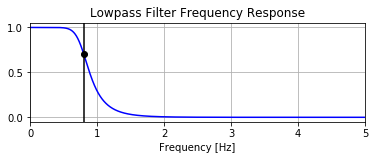

In [11]:
# Filter requirements.
order = 5
fs = 10        # sample rate, Hz
cutoff = 0.8   # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

FileUtilities initialized


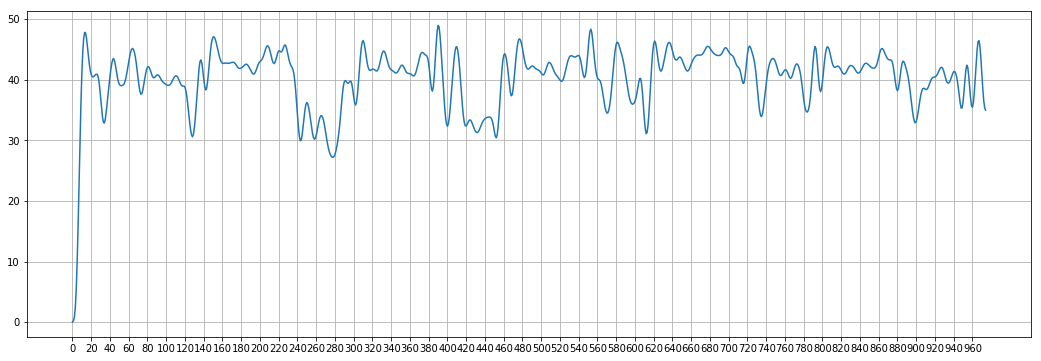

In [12]:
# path = '~/Documents/git-aryans/csi-data-parser/matlab/process_data/'
path = '/Users/Apple/Documents/git-aryans/data/walking_loc_liv/'

# input_file = 'LivingToBed1-parsed.csv'
# input_file = 'LivingToBed2-parsed.csv'
# input_file = 'LivingToKitchen1-parsed.csv'
input_file = 'LivingToKitchen2-parsed.csv'
# input_file = 'BedToBath1-parsed.csv'
# input_file = 'BedToBath2-parsed.csv'

utl = FileUtilities(path)
df = utl.read_csv(path+input_file)
data = utl.get_data_matrix(df)
plt.figure(figsize=(18,6))
plt.grid()
s = data[:,20]
# s1 = np.sum(s,axis=1)
# plt.plot(s)
y = butter_lowpass_filter(s, cutoff, fs, order)
x = y.shape[0]
plt.xticks(np.arange(0, x, 20))
plt.plot(np.arange(0,x),y)

In [13]:
path = '/Users/Apple/Documents/git-aryans/data/walking_loc_liv/walk-all/'
files = os.listdir(path)
utl = FileUtilities(path)
histograms = []
paths = []

for file in files:
    print(file)
    paths.append(file)
    freq = get_hist(utl,path,file)
    histograms.append(freq)
#     plot_hist(freq)

paths = np.array(paths)

FileUtilities initialized
walk-liv-kit-1.csv
walk-liv-kit-3.csv
walk-liv-kit-2.csv
walk-liv-kit-6.csv
walk-liv-kit-7.csv
walk-liv-kit-5.csv
walk-liv-kit-4.csv
walk-liv-bed-8.csv
walk-liv-bed-9.csv
walk-liv-bed-2.csv
walk-liv-bed-3.csv
walk-liv-bed-1.csv
walk-liv-kit-10.csv
walk-liv-bed-4.csv
walk-liv-bed-5.csv
walk-liv-bed-10.csv
walk-liv-bed-7.csv
walk-liv-bed-6.csv
walk-liv-kit-9.csv
walk-liv-kit-8.csv


In [14]:
print(paths)

['walk-liv-kit-1.csv' 'walk-liv-kit-3.csv' 'walk-liv-kit-2.csv'
 'walk-liv-kit-6.csv' 'walk-liv-kit-7.csv' 'walk-liv-kit-5.csv'
 'walk-liv-kit-4.csv' 'walk-liv-bed-8.csv' 'walk-liv-bed-9.csv'
 'walk-liv-bed-2.csv' 'walk-liv-bed-3.csv' 'walk-liv-bed-1.csv'
 'walk-liv-kit-10.csv' 'walk-liv-bed-4.csv' 'walk-liv-bed-5.csv'
 'walk-liv-bed-10.csv' 'walk-liv-bed-7.csv' 'walk-liv-bed-6.csv'
 'walk-liv-kit-9.csv' 'walk-liv-kit-8.csv']


In [15]:
# print(freq)
ed = EarthMovingDistance(histograms)
M = ed.get_EMD_matrix()
# print(M)
min_dis = np.zeros(M.shape[0])
min_idx = np.zeros(M.shape[0]).astype(int)
for i in range(M.shape[0]):
    mn = float("inf")
    idx = i
    for j in range(M.shape[1]):
        if (M[i][j] == 0):
            continue;
        elif (M[i][j] < mn):
            mn = min(mn,M[i][j])
            idx = j
    min_dis[i] = mn
    min_idx[i] = idx

predicted_paths = paths[min_idx]
    
print()
print(min_dis)
print(paths[min_idx])
print(paths)

EarthMovingDistance classifier initialized
Calculating EMD matrix for 20 histograms
EMD matrix calculated!

[   7202.90629785    2764.86225402    3564.75474549    2764.86225402
    3564.75474549    7145.94252728  105413.00454982    2508.7508837
    4707.77944036    2461.95311981    3986.97282036    2461.95311981
    4585.7675061     2781.8966181     3986.97282036    2508.7508837
    2781.8966181    12707.09923289    3561.00553971    4585.7675061 ]
['walk-liv-kit-7.csv' 'walk-liv-kit-6.csv' 'walk-liv-kit-7.csv'
 'walk-liv-kit-3.csv' 'walk-liv-kit-2.csv' 'walk-liv-kit-2.csv'
 'walk-liv-kit-1.csv' 'walk-liv-bed-10.csv' 'walk-liv-kit-6.csv'
 'walk-liv-bed-1.csv' 'walk-liv-bed-5.csv' 'walk-liv-bed-2.csv'
 'walk-liv-kit-8.csv' 'walk-liv-bed-7.csv' 'walk-liv-bed-3.csv'
 'walk-liv-bed-8.csv' 'walk-liv-bed-4.csv' 'walk-liv-bed-1.csv'
 'walk-liv-kit-3.csv' 'walk-liv-kit-10.csv']
['walk-liv-kit-1.csv' 'walk-liv-kit-3.csv' 'walk-liv-kit-2.csv'
 'walk-liv-kit-6.csv' 'walk-liv-kit-7.csv' 'walk-liv-k

In [17]:
y = extract_label(predicted_paths)
x = extract_label(paths)
print(x)
print(y)
print("Accuracy = ",end="")
print(str(accuracy_score(x,y)*100) + '%')

['liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-kit', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-kit', 'liv-kit']
['liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-kit', 'liv-bed', 'liv-kit', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-kit', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-bed', 'liv-kit', 'liv-kit']
Accuracy = 95.0%
